In [1]:
import pathlib
import numpy as np
import healpy as hp
import skyproj
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import astropy.coordinates
from astropy import units as u
from scipy import stats
import galstreams #contains stream data
%matplotlib inline

CURRENT_DIR = pathlib.Path.cwd().resolve()
DATA_DIR = CURRENT_DIR.parent / 'data'

## Functions

In [2]:
def change_coord(m, coord):   
    """ Change coordinates of a HEALPIX mapc

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

 # from https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-system

In [3]:
import numpy as np
from scipy.spatial import cKDTree

def spread_clusters_kernel(points, radius, k=0.1, max_iter=100, tol=1e-6, min_repulsion=0.01):
    """
    DISCLAIMER: Made with DeepSeek, not properly tested, use at your own risk

    Spread apart points that are too close using a kernel-based approach.
    
    Parameters:
    -----------
    points : np.ndarray
        (N, 2) array of x,y coordinates
    radius : float
        Points within this distance are considered "too close"
    k : float
        Strength of the repulsion force (0.1 is a good starting value)
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance
    min_repulsion : float
        Minimum repulsion to apply (avoids numerical issues)
    
    Returns:
    --------
    np.ndarray: Adjusted points
    """
    points = points.copy().astype(float)
    n_points = len(points)
    
    # Build KD-tree for efficient nearest neighbor queries
    tree = cKDTree(points)
    
    for iteration in range(max_iter):
        max_displacement = 0
        new_points = points.copy()
        
        # For each point, find all neighbors within radius
        for i in range(n_points):
            # Query all points within radius (including self)
            indices = tree.query_ball_point(points[i], radius)
            
            if len(indices) <= 1:
                # Isolated point, skip
                continue
                
            # Get vectors from current point to all neighbors
            vectors = points[indices] - points[i]
            distances = np.linalg.norm(vectors, axis=1)
            
            # Remove self (distance = 0)
            mask = distances > 0
            vectors = vectors[mask]
            distances = distances[mask]
            
            if len(distances) == 0:
                continue
            
            # Calculate repulsion for each neighbor based on distance
            # Using an inverse square kernel: stronger repulsion for closer points
            repulsion_weights = k * (1.0 - distances / radius)**2
            
            # Also consider density: more neighbors = stronger overall repulsion
            density_factor = len(distances) / (np.pi * radius**2)
            repulsion_weights *= (1 + density_factor)
            
            # Ensure minimum repulsion
            repulsion_weights = np.maximum(repulsion_weights, min_repulsion)
            
            # Calculate displacement direction vectors (normalized)
            norm_vectors = vectors / distances[:, np.newaxis]
            
            # Sum repulsion vectors weighted by kernel
            displacement = np.sum(norm_vectors * repulsion_weights[:, np.newaxis], axis=0)
            
            # Apply displacement
            new_points[i] += displacement
            
            # Track maximum displacement for convergence check
            max_displacement = max(max_displacement, np.linalg.norm(displacement))
        
        # Update points
        points = new_points
        
        # Update KD-tree with new positions
        tree = cKDTree(points)
        
        # Check convergence
        if max_displacement < tol:
            break
    
    return points


In [4]:
#plots the nearby galaxies (requires nbg.cat list of galaxies)

def plot_galaxies(sp, gals=None, glist=None, annotate=False, glabels=None,radec = False):
    """ plots all galaxies within 10 Mpc 
    (requires nbg.cat--- file with table of galaxies from Karachentsev et al)

    Parameters
    ----------
    sp : skyproj object
      map on which to plot the galaxies
    glist: list of integers
      list of indices for galaxies to label
      if None, plots the whole table
    glabels: list of strings
      labels for the galaxies
      if None, numbers them 1 to N
    Returns
    -------
    cbh : figure handle containing information needed to produce a colorbar 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """
    from matplotlib.colors import LogNorm
    import pandas as pd
    from astropy import units as u
    from astropy.coordinates import SkyCoord


    if gals is None:
    #read and process the table
        nbg, nbgs = read_galaxies()
        dists = nbg['D (Mpc)']*u.Mpc
        norm = LogNorm(vmin=0.2,vmax=10)
        r = 80
    else:
        if 'RAJ2000' in gals.keys():
            ras=[]
            decs=[]
            hms_str = ['h','m','s']
            dms_str = ['d','m','s']
            for i in range(len(gals)):
                ra_str=gals['RAJ2000'][i].split(' ')
                dec_str = gals['DEJ2000'][i].split(' ')
                ras.append("".join(x+y for x,y in zip(ra_str,hms_str)))
                decs.append("".join(x+y for x,y in zip(dec_str,dms_str)))
            nbgs=SkyCoord(ras,decs)
            dists = gals['D (Mpc)']
            norm = LogNorm(vmin=0.2,vmax=10)
            r = 80
        else:
            nbgs=SkyCoord(gals['ra'].values*u.deg,gals['dec'].values*u.deg)
            dists = ((gals['distance'].values*u.kpc).to(u.Mpc)).value
            norm = LogNorm(vmin=15,vmax=350)
            r = 60
    #set up the colormap (log distance)
    cmap = plt.get_cmap('cividis')
    #norm = LogNorm() #(vmin=0.2,vmax=10.)

    #plot the galaxies
    if glist is None:
        if radec:
            cbh = sp.scatter(nbgs.ra.value, nbgs.dec.value, c=dists,  edgecolors= "black", cmap=cmap, norm=norm, s=40,zorder=99)
        else:
            cbh = sp.scatter(nbgs.galactic.l.value, nbgs.galactic.b.value, c=dists,  edgecolors= "black", cmap=cmap, norm=norm, s=40,zorder=99)
    else:
        if radec:
            cbh = sp.scatter(nbgs.ra.value[glist], nbgs.dec.value[glist], c=dists[glist],  edgecolors= "black", cmap=cmap, norm=norm, s=40,zorder=99)
        else:            
            cbh = sp.scatter(nbgs.galactic.l.value[glist], nbgs.galactic.b.value[glist], c=dists[glist],  edgecolors= "black", cmap=cmap, norm=norm, s=40,zorder=99)
        #label the ones listed
        if annotate:
            if glabels is None:
                glabels = np.arange(1, len(glist)+1).astype('str')
            xy_positions = []
            for i, l in enumerate(glabels):
                if radec:
                    x,y = sp.proj(nbgs[glist[i]].ra.deg, nbgs[glist[i]].dec.deg)
                else:
                    x,y = sp.proj(nbgs[glist[i]].galactic.l.deg, nbgs[glist[i]].galactic.b.deg)
                xy_positions.append([x[0],y[0]])
            xy_positions = np.array(xy_positions)
            # if radec:
            #     theta_pole = nbgs.ra.rad[glist]
            # else:
            #     theta_pole = nbgs.galactic.l.rad[glist]
            xy_center = np.mean(xy_positions, axis=0)
            theta_pole = np.arctan2(*tuple((xy_positions-xy_center).T))
            # inverse_theta_order = np.argsort(np.argsort(theta_pole))
            # theta = np.linspace(0, 2*np.pi,len(glist)+1)[inverse_theta_order]-np.pi/2
            theta = theta_pole+np.pi/2
            xyt_positions = (xy_positions.T + [r*np.cos(theta), r*np.sin(theta)]).T
            xyt_positions = [4,1]*spread_clusters_kernel(xyt_positions*[1/4,1], radius=10, k=10)
            xyt_positions -= xy_positions
            for i, l in enumerate(glabels):
                x,y = xy_positions[i]
                # if radec:
                #     x,y = sp.proj(nbgs[glist[i]].ra.deg, nbgs[glist[i]].dec.deg)
                # else:
                #     x,y = sp.proj(nbgs[glist[i]].galactic.l.deg, nbgs[glist[i]].galactic.b.deg)
                # theta = np.linspace(0, 2*np.pi,len(glist)+1)-np.pi/2
                # costh = np.cos(theta[i])
                # sinth = np.sin(theta[i])
                # #costh = 2 * np.random.rand() - 1
                # #sgn = np.sign(2 * np.random.rand() - 1)
                # xt, yt = r*costh, r*sinth
                xt, yt = xyt_positions[i]
                sp.ax.annotate(l.strip(' '), (x,y), (xt,yt),textcoords='offset points',arrowprops=dict(arrowstyle='-',color='k'),va='top',ha='left', **(annotate if isinstance(annotate, dict) else {}))
        
    return cbh

In [5]:
def read_galaxies():
    """ reads list of all galaxies within 10 Mpc 
    (requires nbg.cat--- file with table of galaxies from Karachentsev et al)
      
    Returns
    -------
    nbg : pandas dataframe with table in it
    nbgs : list of skycoords for each galaxy 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """

    import pandas as pd
    #read and process the table
    nbg=pd.read_csv(DATA_DIR / 'nbg.cat',sep="|",usecols=range(1,13))
    ras=[]
    decs=[]
    hms_str = ['h','m','s']
    dms_str = ['d','m','s']
    for i in range(len(nbg)):
        ra_str=nbg['RA J2000  '][i].split(' ')
        dec_str = nbg['DEC J2000'][i].split(' ')
        ras.append("".join(x+y for x,y in zip(ra_str,hms_str)))
        decs.append("".join(x+y for x,y in zip(dec_str,dms_str)))
    nbgs= astropy.coordinates.SkyCoord(ras,decs)
    #rename columns to be consistent with the other file of galaxies
    nbg=nbg.rename(columns={'Gal. Name    ':'Name', 'RA J2000  ':'RAJ2000', 'DEC J2000':'DEJ2000', 'Bmag ':'Bmag', ' Kmag ':'Kmag',
       ' D (Mpc)':'D (Mpc)', '  HRV (km/s)   ':'HRV (km/s)', 'AbsBmag ':'BMag', 'Maj_arcmin':'Maj. Diam (arcmin)'})

    return nbg, nbgs

In [41]:
def read_galaxies_all(dmax = 10*u.Mpc):
    """ reads list of all galaxies within dmax (default 10 Mpc) 
    (requires nbg.csv--- file with table of galaxies from Karachentsev et al 2013)
      
    Returns
    -------
    nbg : pandas dataframe with table in it
    nbgs : list of skycoords for each galaxy 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """

    import pandas as pd
    #read and process the table
    nbg_all=pd.read_csv(DATA_DIR / 'nbgs.csv')
    ras = nbg_all['RAJ2000'].values*u.deg
    decs = nbg_all['DEJ2000'].values*u.deg
    dsel = nbg_all['D (Mpc)']<dmax.to(u.Mpc)
    nbgs_all= astropy.coordinates.SkyCoord(ras[dsel],decs[dsel])

    return nbg_all[dsel], nbgs_all

In [7]:
def get_footprint(coords = 'G'):
    import healpy as hp
    # Read maps with the "tiles" covered -- these are built from APT's outputs
    HLWAS_wide = hp.read_map(DATA_DIR / 'HLWAS_WIDE_0328_APT994_1024.fits.gz')
    HLWAS_medium = hp.read_map(DATA_DIR / 'HLWAS_MEDIUM_0328_APT994_1024.fits.gz')
    maps = [HLWAS_wide, HLWAS_medium]
    
    #combine maps
    combined_map = np.zeros_like(HLWAS_wide)
    for i, m in enumerate(maps):
        m[m==hp.UNSEEN] = 0.
        combined_map[m!=0] = (i+1)*1.0

    combined_map[combined_map <=0] = hp.UNSEEN # Fill back with UNSEEN

    if coords=='G':
        combined_map = change_coord(combined_map,['C','G'])
    
    return combined_map


In [8]:
def read_satellites():
    import pandas as pd
    nbglm=pd.read_csv(DATA_DIR / 'Roman_MW_Dwarf_Targets.csv')
    return nbglm

In [9]:
def select_galaxies_in_footprint(fp, nbg_coords, nbgs):
    """
    selects all the galaxies in the provided footprint fp. 
    nbg_coords is a SkyCoord object with a list of the sky coordinates of the galaxies.
    nbgs is a table of info for the galaxies.
    """
    gn=[]
    gs=[]
    for i,sat in enumerate(nbg_coords):
        ipix = hp.ang2pix(hp.get_nside(fp),sat.galactic.l.value, sat.galactic.b.value,lonlat=True)
        if not fp[ipix]==hp.UNSEEN:
            if sat.galactic.b.value > 0:
                gn.append(i)
            else:
                gs.append(i)
    in_mw = set(np.where(nbgs['D (Mpc)']<0.3)[0].astype(int))
    #remove MW satellites
    nbgs_north = set(gn)
    nbgs_south = set(gs)

    nbgs_in_hlwas_north = list(nbgs_north.difference(in_mw))
    nbgs_in_hlwas_south = list(nbgs_south.difference(in_mw))

    nbgs_in_hlwas_north.sort()
    nbgs_in_hlwas_south.sort()

    print(len(nbgs_in_hlwas_north),'galaxies in northern footprint')
    print(len(nbgs_in_hlwas_south),'galaxies in southern footprint')
    return nbgs_in_hlwas_north, nbgs_in_hlwas_south
    
def select_satellites_in_footprint(fp,nbglm):
    nbglm_in_hlwas_north=[]
    nbglm_in_hlwas_south=[]
    for i in range(len(nbglm)):
        coord = astropy.coordinates.SkyCoord(nbglm['ra'][i]*u.deg,nbglm['dec'][i]*u.deg)
        ipix = hp.ang2pix(hp.get_nside(fp),coord.galactic.l.value, coord.galactic.b.value,lonlat=True)
        if not fp[ipix]==hp.UNSEEN:
            if coord.galactic.b.value > 0:
                nbglm_in_hlwas_north.append(i)
            else:
                nbglm_in_hlwas_south.append(i)
    print(len(nbglm_in_hlwas_north),'satellites in northern footprint')
    print(len(nbglm_in_hlwas_south),'satellites in southern footprint')    
    return nbglm_in_hlwas_north, nbglm_in_hlwas_south

In [10]:
def plot_polar_projection(fp, gals, glist, whichpole, glabels=None, alph=1.0):

    
    # Create a custom colorbar for the 3 maps
    from matplotlib.colors import ListedColormap
    import matplotlib
    # Design the color mapping
    col_dict = {1: "palegreen", 
                2: "limegreen"}
    
    # Create a colormap from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Make patches for the legend
    patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
    patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
    
    # Define labels
    labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM"])
    len_lab = len(labels)

    fig, ax = plt.subplots(figsize=(8,8))
    if whichpole == 'S':
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])
        im, _, _, _ = sp.draw_hpxmap(fp, lon_range=(0,360), lat_range=(-90, -10), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
    else:
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=90.0, galactic=True, extent=[0,360, 10,90])
        im, _, _, _ = sp.draw_hpxmap(fp, lon_range=(0,360), lat_range=(10,90), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
    
    
    cbh = plot_galaxies(sp,gals, glist=glist,annotate=True,glabels=glabels)
    shandles=[patch_HLWAS_m,patch_HLWAS_w]
    handles, labels = sp.ax.get_legend_handles_labels()
    shandles.extend(handles)
    
    sp.legend(handles=shandles, loc='upper left', ncol=2,  fontsize=10, bbox_to_anchor=(0.0,0.0, 1.0, 0.05))
    
    sp.ax.tick_params(axis="x", labelsize=14)
    sp.ax.tick_params(axis="y", labelsize=14)
    cb=plt.colorbar(cbh, shrink=0.8)
    cb.set_label(label='Distance (Mpc)', size=16)
    cb.ax.tick_params(labelsize=16)
    plt.tight_layout(h_pad=0.1,w_pad=0.1)
    return fig

In [11]:
def plot_polar_projection_new(fp, gals, glist, whichpole, glabels=None, alph=1.0, annotate=True, scaled_gmap=None, ax=None, no_legend=False, no_cbar=False):

    
    # Create a custom colorbar for the 3 maps
    from matplotlib.colors import ListedColormap
    import matplotlib
    # Design the color mapping
    col_dict = {1: "palegreen", 
                2: "limegreen"}
    
    # Create a colormap from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Make patches for the legend
    patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
    patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
    
    # Define labels
    labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM"])
    len_lab = len(labels)

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    
    if whichpole == 'S':
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])
        lon_range=(0,360)
        lat_range=(-90, -10)
    else:
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=90.0, galactic=True, extent=[0,360, 10,90])
        lon_range=(0,360)
        lat_range=(10,90)
    
    if scaled_gmap is not None:
        sp.draw_hpxmap(scaled_gmap,alpha=0.9,cmap='gray_r',vmin=0.5,vmax=5.0, lon_range=lon_range, lat_range=lat_range)
    
    im, _, _, _ = sp.draw_hpxmap(fp, lon_range=lon_range, lat_range=lat_range, alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
    
    cbh = plot_galaxies(sp,gals, glist=glist,annotate=annotate,glabels=glabels)

    shandles=[patch_HLWAS_m,patch_HLWAS_w]
    handles, labels = sp.ax.get_legend_handles_labels()
    shandles.extend(handles)
    
    if not no_legend:
        sp.legend(handles=shandles, loc='upper left', ncol=2,  fontsize=10, bbox_to_anchor=(0.0,0.0, 1.0, 0.05))
    
    sp.ax.tick_params(axis="x", labelsize=14)
    sp.ax.tick_params(axis="y", labelsize=14)

    if not no_cbar:
        cb=plt.colorbar(cbh, shrink=0.8)
        cb.set_label(label='Distance (Mpc)', size=16)
        cb.ax.tick_params(labelsize=16)
    
    plt.tight_layout(h_pad=0.1,w_pad=0.1)
    return sp, cbh
    

In [12]:
def add_extra_galaxies(sp, cbh=None, nbg_coords=None, dists=None, glist=None, radec=False, dmax=10*u.Mpc):
    """
    adds nonlabeled galaxies out to distance dmax to plot with handle sp and scalar mappable cbh
    if the coordinates are not supplied they will be read using read_galaxies_all()
    if coordinates are supplied but not distances, or no mappable is supplied, galaxies will be plotted as small gray dots
    if both coords and distances are supplied (or neither), galaxies will be plotted with color ~ log(distance)
    radec=False produces a plot in Galactic coordinates
    
    """
    if nbg_coords is None:
        nbg, nbg_coords = read_galaxies_all(dmax=dmax)
        dists = nbg['D (Mpc)']
    if glist is None:
        nbg_to_plot = nbg_coords
        dists_to_plot = dists
    else:
        nbg_to_plot = nbg_coords[glist]
    if dists is None or cbh is None:  #just plot gray dots
        if radec:
            sp.plot(nbg_to_plot.ra.value, nbg_to_plot.dec.value, 'o', mfc='gray', mec='none', size=2,zorder=95)
        else:
            sp.plot(nbg_to_plot.galactic.l.value, nbg_to_plot.galactic.b.value, 'o', mfc='gray', mec='none', size=2,zorder=95)
        return sp
    else: #plot smaller than labeled galaxies, with colorscale and colormap pulled from the provided scalar mappable
        norm = cbh.norm
        cmap= cbh.get_cmap()
        if glist is not None: 
            dists_to_plot = dists[glist]
        if radec:
                cbh = sp.scatter(nbg_to_plot.ra.value, nbg_to_plot.dec.value, c=dists_to_plot,  edgecolors= "none", cmap=cmap, norm=norm, s=30,zorder=95)
        else:
                cbh = sp.scatter(nbg_to_plot.galactic.l.value, nbg_to_plot.galactic.b.value, c=dists_to_plot,  edgecolors= "none", cmap=cmap, norm=norm, s=30,zorder=95)        
        return sp, cbh


## Plotting

In [13]:
combined_map_gal = get_footprint()

In [42]:
nbgs, nbg_coords = read_galaxies()
nbgs_all, nbg_coords_all = read_galaxies_all(dmax=10*u.Mpc)
nbglm = read_satellites()

In [43]:
nbgs_in_hlwas_north, nbgs_in_hlwas_south = select_galaxies_in_footprint(combined_map_gal, nbg_coords, nbgs)

10 galaxies in northern footprint
15 galaxies in southern footprint


In [45]:
nbgs_in_hlwas_north_all, nbgs_in_hlwas_south_all = select_galaxies_in_footprint(combined_map_gal, nbg_coords_all, nbgs_all)

34 galaxies in northern footprint
29 galaxies in southern footprint


In [16]:
nbglm_in_hlwas_north, nbglm_in_hlwas_south = select_satellites_in_footprint(combined_map_gal,nbglm)

6 satellites in northern footprint
8 satellites in southern footprint


In [17]:
import pandas as pd

virgo = pd.read_csv(DATA_DIR / 'fnx_virgo_gals.csv')

In [18]:
from astropy import units as u
from astropy.coordinates import SkyCoord

vgals = SkyCoord(virgo['RA-s'][virgo['Dec']>-10],virgo['Dec-s'][virgo['Dec']>-10])
fgals = SkyCoord(virgo['RA-s'][virgo['Dec']<-10],virgo['Dec-s'][virgo['Dec']<-10])

In [19]:
from scipy.spatial import ConvexHull
from shapely import Polygon

vhull_gal_buffer = 1.

vhull_gal = ConvexHull(np.vstack([vgals.galactic.l.deg, vgals.galactic.b.deg]).T)
vhull_gal.close()
vhull_gal_edges = vhull_gal.points[vhull_gal.vertices]
vhull_gal_poly = Polygon(vhull_gal_edges)
vhull_gal_buffer_poly = vhull_gal_poly.buffer(vhull_gal_buffer, quad_segs=8)
vhull_gal_buffer_poly_edges = np.array(list(vhull_gal_buffer_poly.boundary.coords))
vhull_gal_buffer_poly_path = vhull_gal_buffer_poly_edges[np.arange(vhull_gal_buffer_poly_edges.shape[0]+1) % vhull_gal_buffer_poly_edges.shape[0]]

fhull_gal_buffer = 1.

fhull_gal = ConvexHull(np.vstack([fgals.galactic.l.deg, fgals.galactic.b.deg]).T)
fhull_gal.close()
fhull_gal_edges = fhull_gal.points[fhull_gal.vertices]
fhull_gal_poly = Polygon(fhull_gal_edges)
fhull_gal_buffer_poly = fhull_gal_poly.buffer(fhull_gal_buffer, quad_segs=8)
fhull_gal_buffer_poly_edges = np.array(list(fhull_gal_buffer_poly.boundary.coords))
fhull_gal_buffer_poly_path = fhull_gal_buffer_poly_edges[np.arange(fhull_gal_buffer_poly_edges.shape[0]+1) % fhull_gal_buffer_poly_edges.shape[0]]


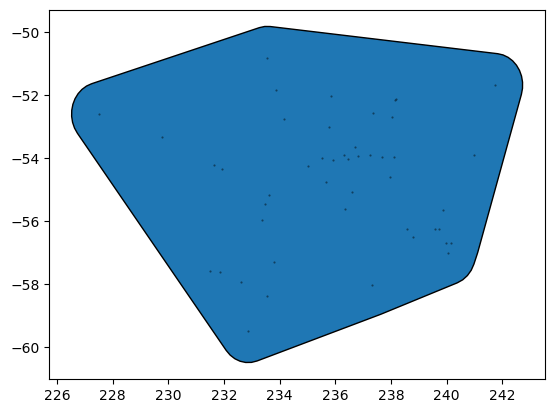

In [20]:
plt.plot(fgals.galactic.l.deg, fgals.galactic.b.deg,'.k',ms=1,alpha=0.5)

fhull_gal_path = fhull_gal_buffer_poly_path[np.arange(fhull_gal_buffer_poly_path.shape[0]+1) % fhull_gal_buffer_poly_path.shape[0]]
plt.gca().add_patch(mpatches.PathPatch(mpath.Path(fhull_gal_path)))

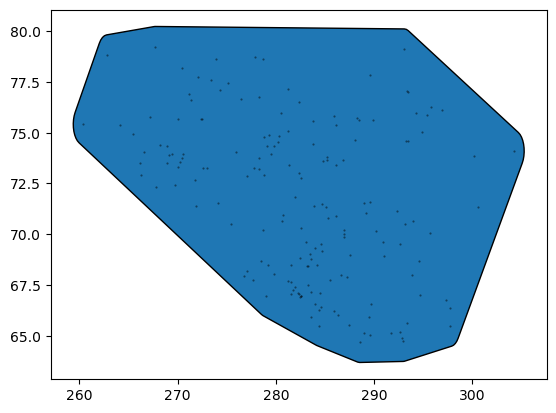

In [21]:
plt.plot(vgals.galactic.l.deg, vgals.galactic.b.deg,'.k',ms=1,alpha=0.5)

vhull_gal_path = vhull_gal_buffer_poly_path[np.arange(vhull_gal_buffer_poly_path.shape[0]+1) % vhull_gal_buffer_poly_path.shape[0]]
plt.gca().add_patch(mpatches.PathPatch(mpath.Path(vhull_gal_path)))

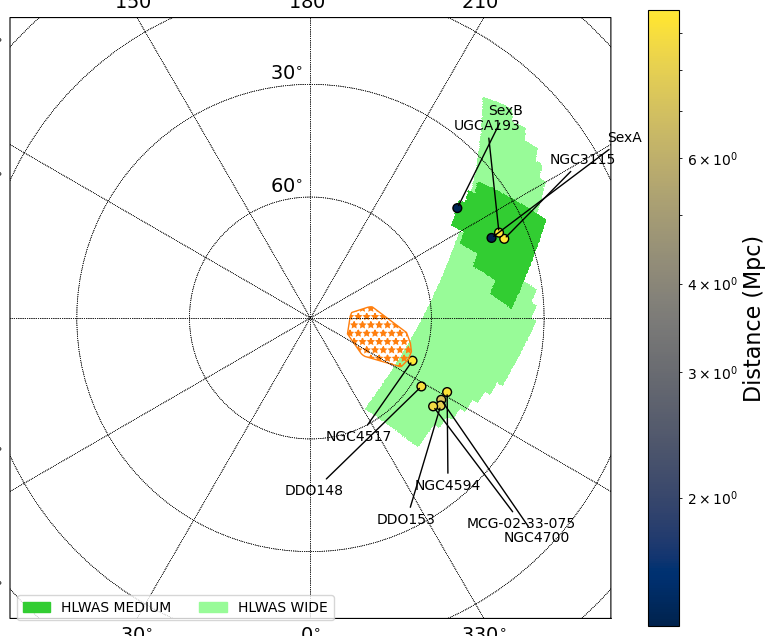

In [51]:
fig_gal_N = plot_polar_projection(combined_map_gal,nbgs,
                                           nbgs_in_hlwas_north,
                                           'N',
                                           glabels=nbgs['Name'][nbgs_in_hlwas_north])
# fig_gal_N.gca().plot(vgals.galactic.l.deg, vgals.galactic.b.deg,'sk',ms=5,alpha=0.1)
fig_gal_N.gca().add_patch(mpatches.PathPatch(mpath.Path(fig_gal_N.gca().projection.transform_points(*tuple(vhull_gal_buffer_poly_path.T))), facecolor='tab:orange', edgecolor="tab:orange", fill=False, hatch='**'))

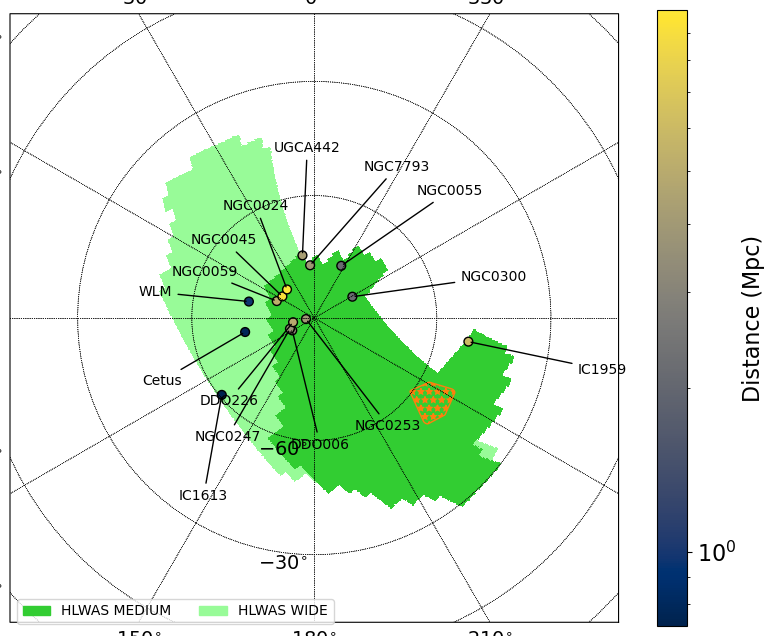

In [52]:
fig_gal_S = plot_polar_projection(combined_map_gal,nbgs,nbgs_in_hlwas_south,'S',glabels=nbgs['Name'][nbgs_in_hlwas_south])
# fig_gal_S.gca().plot(fgals.galactic.l.deg, fgals.galactic.b.deg,'sk',ms=5,alpha=0.1)
fig_gal_S.gca().add_patch(mpatches.PathPatch(mpath.Path(fig_gal_S.gca().projection.transform_points(*tuple(fhull_gal_buffer_poly_path.T))), facecolor='tab:orange', edgecolor="tab:orange", fill=False, hatch='**'))

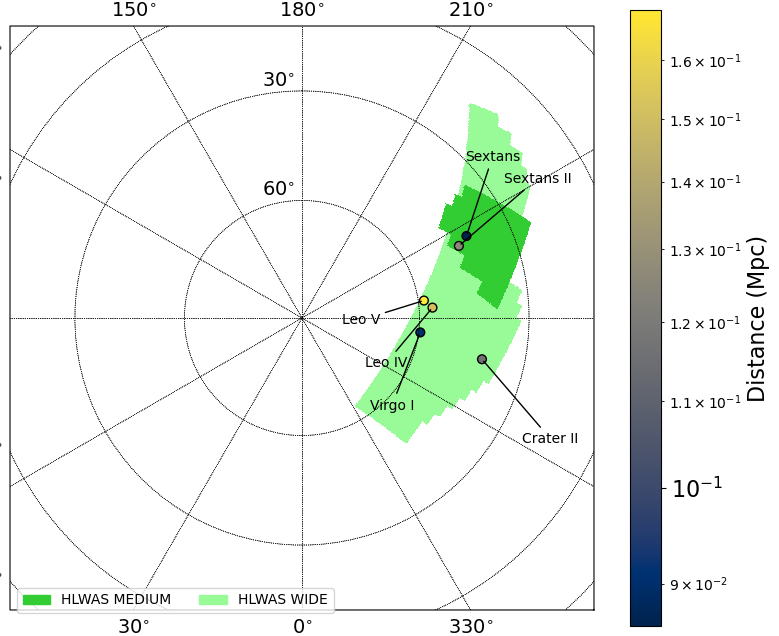

In [53]:
fig_sats_N = plot_polar_projection(combined_map_gal, nbglm, nbglm_in_hlwas_north, 'N', nbglm['name'][nbglm_in_hlwas_north])

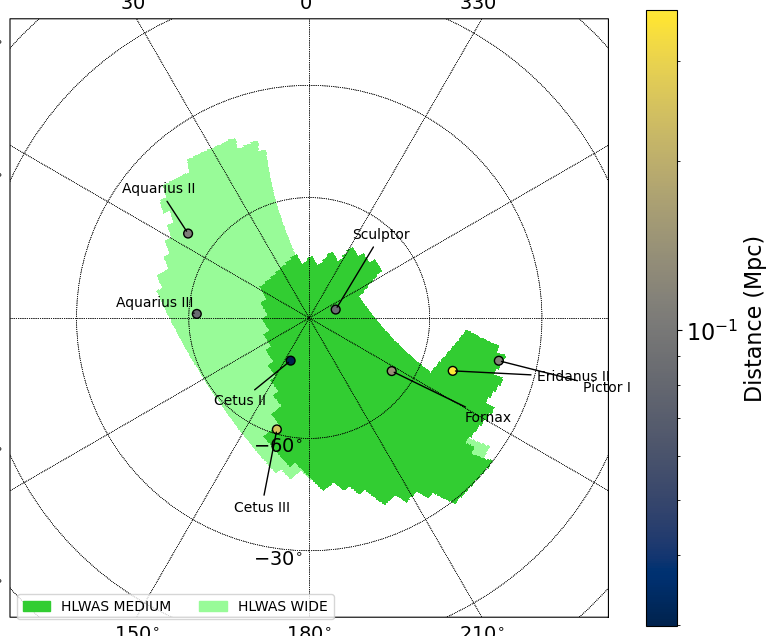

In [54]:
fig_sats_N = plot_polar_projection(combined_map_gal, nbglm, nbglm_in_hlwas_south, 'S', nbglm['name'][nbglm_in_hlwas_south])


In [22]:
from matplotlib.colors import ListedColormap
import matplotlib
# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict = {1: "palegreen", # "lightskyblue",
            2: "limegreen", # "dodgerblue",
            3: "firebrick"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM", "GPS"])
len_lab = len(labels)

In [23]:
vhull_buffer = 1.

vhull = ConvexHull(np.vstack([vgals.icrs.ra.deg, vgals.icrs.dec.deg]).T)
vhull.close()
vhull_edges = vhull.points[vhull.vertices]
vhull_poly = Polygon(vhull_edges)
vhull_buffer_poly = vhull_poly.buffer(vhull_buffer, quad_segs=8)
vhull_buffer_poly_edges = np.array(list(vhull_buffer_poly.boundary.coords))
vhull_buffer_poly_path = vhull_buffer_poly_edges[np.arange(vhull_buffer_poly_edges.shape[0]+1) % vhull_buffer_poly_edges.shape[0]]

fhull_buffer = 1.

fhull = ConvexHull(np.vstack([fgals.icrs.ra.deg, fgals.icrs.dec.deg]).T)
fhull.close()
fhull_edges = fhull.points[fhull.vertices]
fhull_poly = Polygon(fhull_edges)
fhull_buffer_poly = fhull_poly.buffer(fhull_buffer, quad_segs=8)
fhull_buffer_poly_edges = np.array(list(fhull_buffer_poly.boundary.coords))
fhull_buffer_poly_path = fhull_buffer_poly_edges[np.arange(fhull_buffer_poly_edges.shape[0]+1) % fhull_buffer_poly_edges.shape[0]]


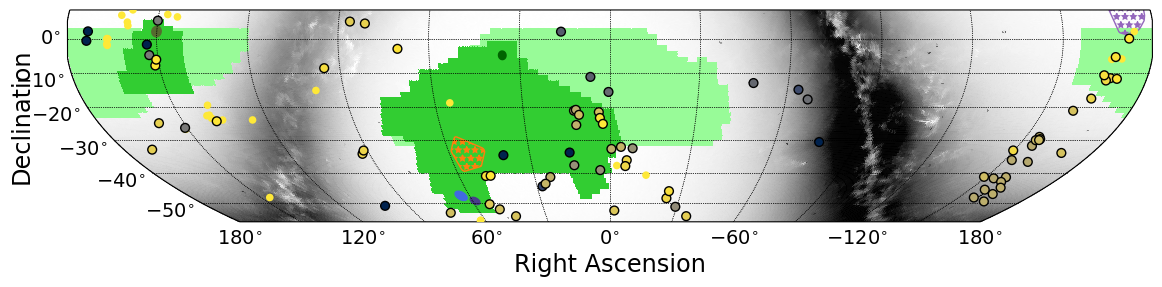

In [24]:
# read in healpix Gaia map
filename = DATA_DIR / 'gaia_stellar_density_map_G_21_gal_nside_128_v0.fits'
gaiamap = hp.read_map(filename)
gaiamap = change_coord(gaiamap, ['G', 'C'])
gaiamap -= np.min(gaiamap)
scale = np.std(gaiamap)*0.2
scaled_gmap = np.arcsinh(gaiamap/scale)

combined_map_cel=get_footprint(coords='C')
#combined_map=change_coord(combined_map, ['G', 'C'])

alph=1.0

fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
sp = skyproj.sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90],  longitude_ticks='symmetric',galactic=False)
sp.draw_hpxmap(scaled_gmap,alpha=0.9,cmap='gray_r',vmin=0.5,vmax=5.0)


im, _, _, _ = sp.draw_hpxmap(combined_map_cel, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

# Add coordinates for GTBDS and HLTDS
gbtds_one = astropy.coordinates.SkyCoord('17h50m16.8700s', '-28d41m11.10s')
gbtds_two = astropy.coordinates.SkyCoord('17h49m53.4700s','-28d49m31.00s')
elais_n1 = astropy.coordinates.SkyCoord('16h10m1.0000s', '+54d30m36.00s')
euclid_s_wide = astropy.coordinates.SkyCoord('04h14m24.0000s', '-47d36m0.00s')
euclid_s_deep = astropy.coordinates.SkyCoord('03h55m36.0000s', '-49d19m12.00s')
hlwas_cosmos = astropy.coordinates.SkyCoord('10h00m24.0000s', '+02d10m55.00s')
hlwas_xmm = astropy.coordinates.SkyCoord('02h22m50.0000s', '-04d45m0.00s')


# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
#sp.circle(gbtds_one.ra.value, gbtds_one.dec.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
#HLTDS
sp.circle(elais_n1.ra.value, elais_n1.dec.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.ra.value, euclid_s_wide.dec.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.ra.value, euclid_s_deep.dec.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
#HLWAS DEEP
sp.circle(hlwas_cosmos.ra.value, hlwas_cosmos.dec.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.ra.value, hlwas_xmm.dec.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)

cbh=plot_galaxies(sp,radec=True)
sp, cbh = add_extra_galaxies(sp, cbh, radec=True)

sp.ax.add_patch(mpatches.PathPatch(mpath.Path(sp.ax.projection.transform_points(*tuple(vhull_buffer_poly_path.T))), facecolor='tab:purple', edgecolor="tab:purple", fill=False, hatch='**'))
sp.ax.add_patch(mpatches.PathPatch(mpath.Path(sp.ax.projection.transform_points(*tuple(fhull_buffer_poly_path.T))), facecolor='tab:orange', edgecolor="tab:orange", fill=False, hatch='**'))

#make legend

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')

handles, labels = sp.ax.get_legend_handles_labels()
#handles.extend([patch_HLWAS_w, patch_HLWAS_m, patch_GPS])
shandles = handles[0:5]
shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
shandles.extend([patch_GPS])
shandles.extend(handles[5:])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

#sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)

plt.show();

/var/folders/kx/ctskvvqs07z_3yv01bc_3slc0000gn/T/ipykernel_38035/1264432598.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


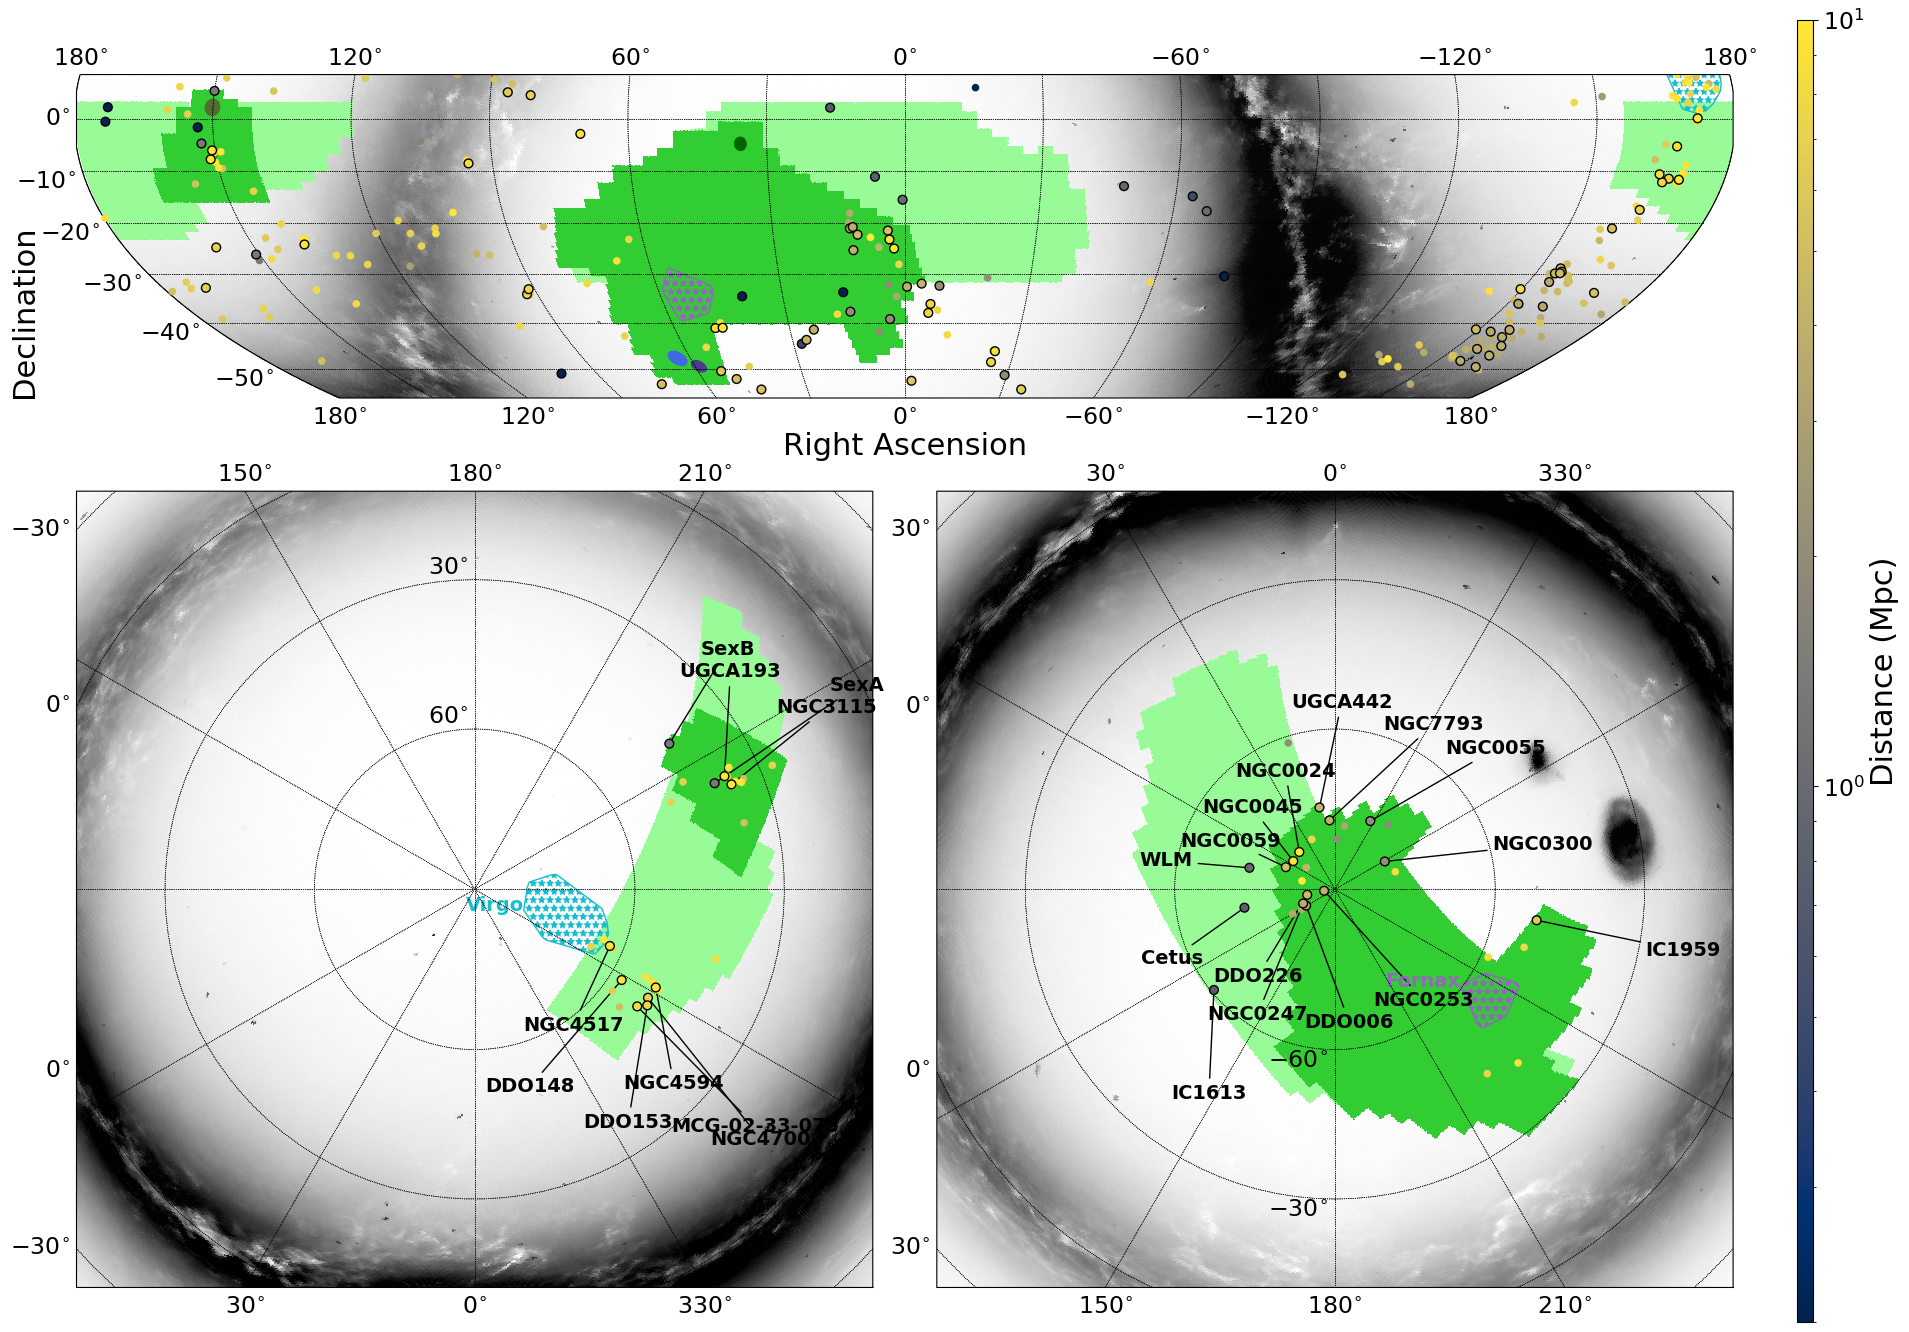

In [46]:
fig = plt.figure(10, figsize=(18, 14))
gs = plt.GridSpec(2, 3, height_ratios=[1, 2], width_ratios=[1, 1, 0.02])

ax = fig.add_subplot(gs[0,:2])
ax_n = fig.add_subplot(gs[1,0])
ax_s = fig.add_subplot(gs[1,1])
ax_cbar = fig.add_subplot(gs[:,2])

v_color = 'tab:cyan'
f_color = 'tab:purple'

ticksize = 17
labelsize = 22

# read in healpix Gaia map
filename = DATA_DIR / 'gaia_stellar_density_map_G_21_gal_nside_128_v0.fits'
gaiamap = hp.read_map(filename)
gaiamap = change_coord(gaiamap, ['G', 'C'])
gaiamap -= np.min(gaiamap)
scale = np.std(gaiamap)*0.2
scaled_gmap = np.arcsinh(gaiamap/scale)

combined_map_cel=get_footprint(coords='C')
#combined_map=change_coord(combined_map, ['G', 'C'])

alph=1.0

sp = skyproj.sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90],  longitude_ticks='symmetric',galactic=False)
sp.draw_hpxmap(scaled_gmap,alpha=0.9,cmap='gray_r',vmin=0.5,vmax=5.0)


im, _, _, _ = sp.draw_hpxmap(combined_map_cel, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

# Add coordinates for GTBDS and HLTDS
gbtds_one = astropy.coordinates.SkyCoord('17h50m16.8700s', '-28d41m11.10s')
gbtds_two = astropy.coordinates.SkyCoord('17h49m53.4700s','-28d49m31.00s')
elais_n1 = astropy.coordinates.SkyCoord('16h10m1.0000s', '+54d30m36.00s')
euclid_s_wide = astropy.coordinates.SkyCoord('04h14m24.0000s', '-47d36m0.00s')
euclid_s_deep = astropy.coordinates.SkyCoord('03h55m36.0000s', '-49d19m12.00s')
hlwas_cosmos = astropy.coordinates.SkyCoord('10h00m24.0000s', '+02d10m55.00s')
hlwas_xmm = astropy.coordinates.SkyCoord('02h22m50.0000s', '-04d45m0.00s')


# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
#sp.circle(gbtds_one.ra.value, gbtds_one.dec.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
#HLTDS
sp.circle(elais_n1.ra.value, elais_n1.dec.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.ra.value, euclid_s_wide.dec.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.ra.value, euclid_s_deep.dec.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
#HLWAS DEEP
sp.circle(hlwas_cosmos.ra.value, hlwas_cosmos.dec.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.ra.value, hlwas_xmm.dec.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)

scatter_cel = plot_galaxies(sp,radec=True)
sp, scatter_cel = add_extra_galaxies(sp, scatter_cel, radec=True)

sp.ax.add_patch(mpatches.PathPatch(mpath.Path(sp.ax.projection.transform_points(*tuple(vhull_buffer_poly_path.T))), facecolor=v_color, edgecolor=v_color, fill=False, hatch='**'))
sp.ax.add_patch(mpatches.PathPatch(mpath.Path(sp.ax.projection.transform_points(*tuple(fhull_buffer_poly_path.T))), facecolor=f_color, edgecolor=f_color, fill=False, hatch='**'))

sp.ax.tick_params(axis="x", labelsize=ticksize)
sp.ax.tick_params(axis="y", labelsize=ticksize)
# sp.ax.yaxis.tick_right()
# sp.ax.yaxis.set_label_position('right')

sp.ax.set_ylabel("Declination", loc='bottom')
sp.ax.xaxis.get_label().set_size(labelsize)
sp.ax.yaxis.get_label().set_size(labelsize)

################################################################

gaiamap = hp.read_map(filename)
gaiamap -= np.min(gaiamap)
scale = np.std(gaiamap)*0.2
scaled_gmap = np.arcsinh(gaiamap/scale)

sp_n, scatter_n = plot_polar_projection_new(combined_map_gal,nbgs,
                                 nbgs_in_hlwas_north,
                                 'N',
                                 glabels=nbgs['Name'][nbgs_in_hlwas_north],
                                 annotate={'fontweight': 'bold', 'fontsize': 14},
                                 scaled_gmap=scaled_gmap, ax=ax_n, no_legend=True, no_cbar=True)
sp_n, scatter_n = add_extra_galaxies(sp_n, scatter_n,glist=nbgs_in_hlwas_north_all)

sp_n.ax.tick_params(axis="x", labelsize=ticksize)
sp_n.ax.tick_params(axis="y", labelsize=ticksize)

v_patch = sp_n.ax.add_patch(mpatches.PathPatch(mpath.Path(sp_n.ax.projection.transform_points(*tuple(vhull_gal_buffer_poly_path.T))), facecolor=v_color, edgecolor=v_color, fill=False, hatch='**'))

sp_n.ax.text(*tuple(vhull_gal_buffer_poly_path[vhull_gal_buffer_poly_path[:,1].argmax()+3]), 'Virgo', ha='right', color=v_color, fontweight='bold', fontsize=14)

################################################################

sp_s, scatter_s = plot_polar_projection_new(combined_map_gal,nbgs,
                                 nbgs_in_hlwas_south,
                                 'S',
                                 glabels=nbgs['Name'][nbgs_in_hlwas_south],
                                 annotate={'fontweight': 'bold', 'fontsize': 14},
                                 scaled_gmap=scaled_gmap, ax=ax_s, no_legend=True, no_cbar=True)
sp_s, scatter_s = add_extra_galaxies(sp_s, scatter_s,glist=nbgs_in_hlwas_south_all)

sp_s.ax.tick_params(axis="x", labelsize=ticksize)
sp_s.ax.tick_params(axis="y", labelsize=ticksize)

f_patch = sp_s.ax.add_patch(mpatches.PathPatch(mpath.Path(sp_s.ax.projection.transform_points(*tuple(fhull_gal_buffer_poly_path.T))), facecolor=f_color, edgecolor=f_color, fill=False, hatch='**'))

sp_s.ax.text(*tuple(fhull_gal_buffer_poly_path[fhull_gal_buffer_poly_path[:,1].argmin()+3]), 'Fornax', ha='right', color=f_color, fontweight='bold', fontsize=14)

################################################################

clim = np.percentile(np.hstack([scatter_cel.get_clim(), scatter_n.get_clim(), scatter_s.get_clim()]), [0,100])

scatter_cel.set_clim(clim)
scatter_n.set_clim(clim)
scatter_s.set_clim(clim)

cb=plt.colorbar(scatter_cel, cax=ax_cbar)
cb.set_label(label='Distance (Mpc)', size=labelsize)
cb.ax.tick_params(labelsize=ticksize)

################################################################

fig.subplots_adjust(bottom=2*fig.subplotpars.bottom,wspace=2*fig.subplotpars.wspace,hspace=3*fig.subplotpars.hspace)

fig.show()